## Imports and Custom Functions

In [1]:
#Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
import nltk
import math


from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', None)

In [2]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()
    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).
    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue
            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())
        processed_texts.append(tokens)
    return processed_texts


## Load and Check Data

In [3]:
df = pd.read_csv("Data/Fake_Real_News_Data.csv")
df.head()

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                             title  \
0     A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone   
1  In Baltimore's call for federal police probe, a new search for answers (+video)   
2             Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It   
3               Inside the Trump-Bush melodrama: Decades of tension and discomfort   
4                                    Shutdown clash to return in force by December   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


## Clean Data

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [7]:
# Drop unnecessary columns
df = df.drop(columns=["Unnamed: 0"])

In [8]:
df.head()

title  \
0     A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone   
1  In Baltimore's call for federal police probe, a new search for answers (+video)   
2             Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It   
3               Inside the Trump-Bush melodrama: Decades of tension and discomfort   
4                                    Shutdown clash to return in force by December   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Tokenize and Lemmatize Data

In [9]:
# Split text by spaces to create tokens
df["tokens"] = df["text"].str.split()
df.head()

title  \
0     A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone   
1  In Baltimore's call for federal police probe, a new search for answers (+video)   
2             Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It   
3               Inside the Trump-Bush melodrama: Decades of tension and discomfort   
4                                    Shutdown clash to return in force by December   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [10]:
# Create spacy object
nlp_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp_model.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [11]:
# Lemmatize text
df["lemmas"] = batch_preprocess_texts(df["text"])

6335it [01:39, 63.50it/s] 


In [12]:
df.head()

title  \
0     A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone   
1  In Baltimore's call for federal police probe, a new search for answers (+video)   
2             Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It   
3               Inside the Trump-Bush melodrama: Decades of tension and discomfort   
4                                    Shutdown clash to return in force by December   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [13]:
# Join lemmas into single string
df["joined_lemmas"] = df["lemmas"].map(lambda x: " ".join(x))
df.head()

title  \
0     A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone   
1  In Baltimore's call for federal police probe, a new search for answers (+video)   
2             Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It   
3               Inside the Trump-Bush melodrama: Decades of tension and discomfort   
4                                    Shutdown clash to return in force by December   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Check Class Balance and Add Length Columnd text

In [14]:
# Check class balance
df["label"].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [15]:
# Create length column using token count
df["length"] = df["tokens"].map(len)
df.head()

title  \
0     A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone   
1  In Baltimore's call for federal police probe, a new search for answers (+video)   
2             Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It   
3               Inside the Trump-Bush melodrama: Decades of tension and discomfort   
4                                    Shutdown clash to return in force by December   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [16]:
# Create variable (typeSeries) for real articles
real_length = df["length"].where(df["label"] == "REAL")

In [17]:
# Create variable (typeSeries) for fake articles
fake_length = df["length"].where(df["label"] == "FAKE")

In [18]:
# Check data for real articles. Average length is 873 words
real_length.describe()

count    3171.000000
mean      873.257647
std       722.483569
min         7.000000
25%       450.500000
50%       771.000000
75%      1123.000000
max      7602.000000
Name: length, dtype: float64

In [19]:
# Check data for fake articles. Average length is 679 words
fake_length.describe()

count     3164.000000
mean       679.129267
std        958.962790
min          0.000000
25%        212.000000
50%        421.000000
75%        830.000000
max      20891.000000
Name: length, dtype: float64

## Frequency Distribution

In [20]:
# Create lists for real and fake lemmas
real_words = df["lemmas"].where(df["label"] == "REAL").explode().to_list()

fake_words = df["lemmas"].where(df["label"] == "FAKE").explode().to_list()

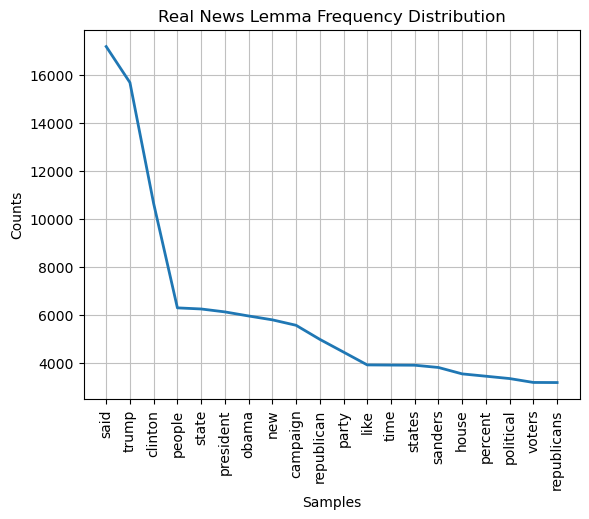

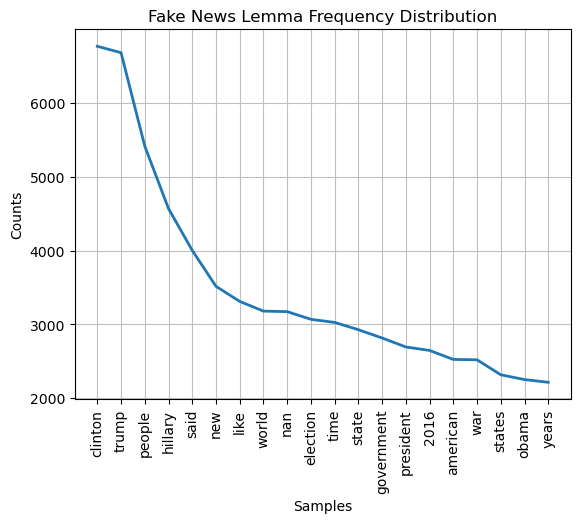

In [21]:
## Instantiate positive frequency distribution
real_freq_dist = FreqDist(real_words)
fake_freq_dist = FreqDist(fake_words)

## Plot the distribution
real_freq_dist.plot(20, title='Real News Lemma Frequency Distribution')

fake_freq_dist.plot(20, title='Fake News Lemma Frequency Distribution');

In [22]:
# Create lists for real and fake joined lemmas
real_words = df["joined_lemmas"].where(df["label"] == "REAL").explode().to_list()

fake_words = df["joined_lemmas"].where(df["label"] == "FAKE").explode().to_list()

In [23]:
# https://stackoverflow.com/questions/10880813/typeerror-sequence-item-0-expected-string-int-found
# Create new variable without NaNs (categorized as floats)
real_words_a = ','.join(str(v) for v in real_words)

fake_words_a = ','.join(str(f) for f in fake_words)


## Word Clouds

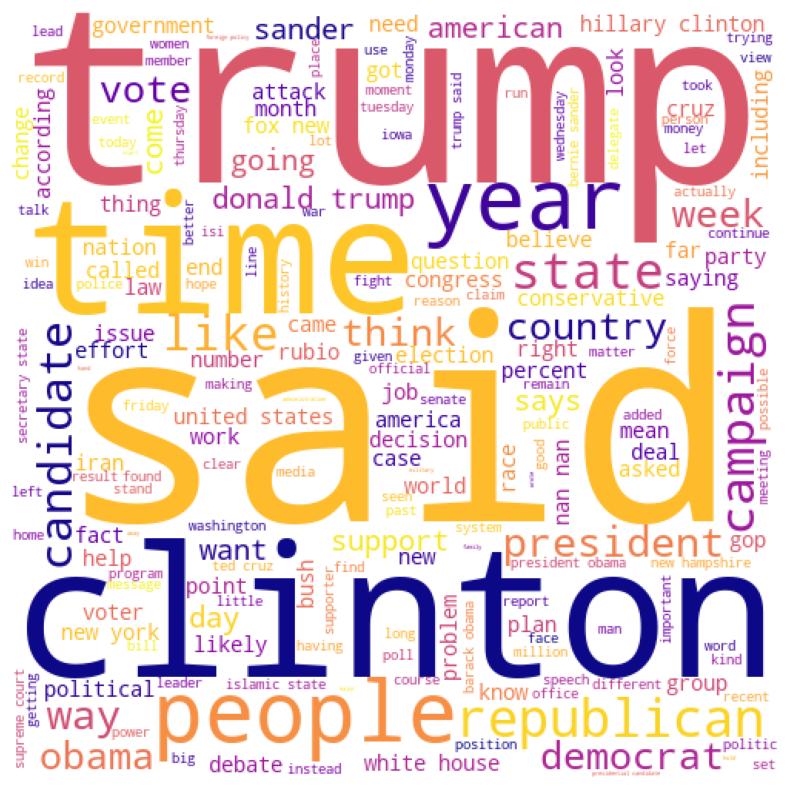

In [24]:
# Create an instance of a WordCloud for the real articles
cloud = WordCloud(
    random_state=123,
    stopwords = [],
    background_color="white",
    width = 500,
    height = 500,
    max_words=200,
    colormap="plasma",
    min_word_length=2,
).generate(real_words_a)

plt.figure(figsize = (10, 10))
plt.imshow(cloud)
plt.axis("off");



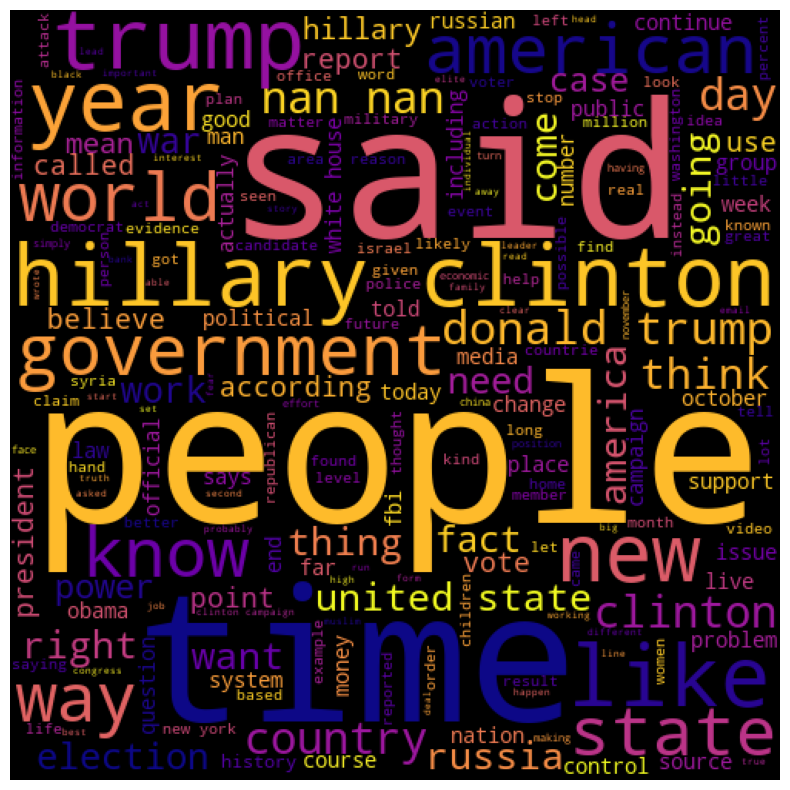

In [25]:
# Create an instance of a WordCloud for the fake articles
cloud = WordCloud(
    random_state=123,
    stopwords = [],
    background_color="black",
    width = 500,
    height = 500,
    max_words=200,
    colormap="plasma",
    min_word_length=2,
).generate(fake_words_a)

plt.figure(figsize = (10, 10))
plt.imshow(cloud)
plt.axis("off");



# Text Classification with Sklearn (Core)

## Additional Imports and Functions

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import itertools
pd.set_option('display.max_colwidth',300)

In [27]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



## Split and Model the Data

In [28]:
# Define X and y
X = df['joined_lemmas']
y = df['label']



In [29]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=42)



## GridsearchCV

In [40]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

param_grid_ngram = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    **param_grid_shared

}


# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]



In [41]:
# Define parameters to tune multiple models

param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]



In [42]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe



Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2393
        REAL       1.00      1.00      1.00      2358

    accuracy                           1.00      4751
   macro avg       1.00      1.00      1.00      4751
weighted avg       1.00      1.00      1.00      4751



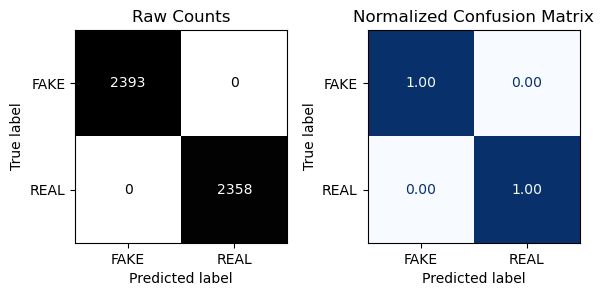


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.91      0.89      0.90       771
        REAL       0.90      0.91      0.90       813

    accuracy                           0.90      1584
   macro avg       0.90      0.90      0.90      1584
weighted avg       0.90      0.90      0.90      1584



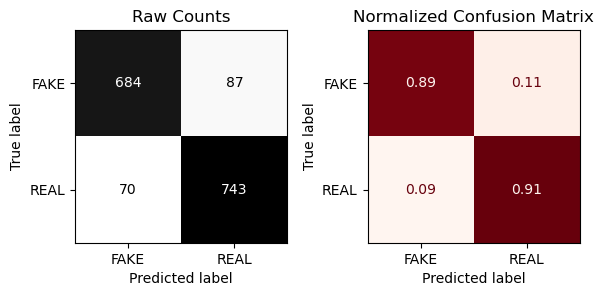

In [43]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Evaluate
evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)



In [44]:

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]



({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'clf': [RandomForestClassifier(random_state=42)],
  'clf__max_depth': [5, None],
  'clf__min_samples_leaf': [1, 2]})

In [45]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]



{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None],
 'clf__min_samples_leaf': [1, 2]}

In [46]:
%%time
# Create grid search
grid_search = GridSearchCV(clf_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
CPU times: total: 4min 53s
Wall time: 52min 28s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [5, None],
                          'clf__min_samples_leaf': [1, 2],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [...
                         {'clf': [LogisticRegression(C=10, random_state=42)],
                          'clf__C': [0.1, 1, 10, 100],
                          'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=2)],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

In [48]:
print(grid_search.best_params_)

{'clf': LogisticRegression(C=10, random_state=42), 'clf__C': 10, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2), 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 2, 'vectorizer__norm': 'l2', 'vectorizer__stop_words': None, 'vectorizer__use_idf': True}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2393
        REAL       1.00      1.00      1.00      2358

    accuracy                           1.00      4751
   macro avg       1.00      1.00      1.00      4751
weighted avg       1.00      1.00      1.00      4751



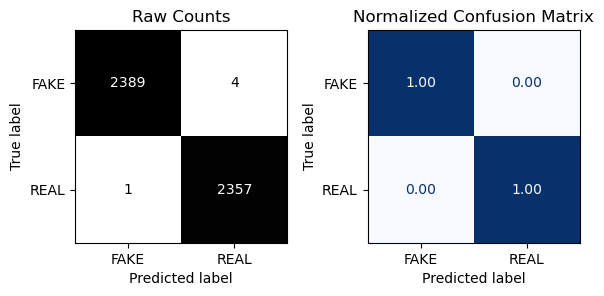


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.91      0.95      0.93       771
        REAL       0.95      0.91      0.93       813

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



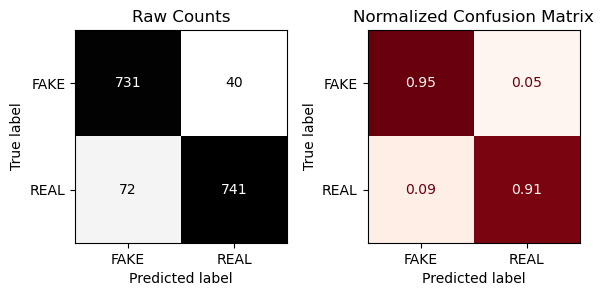

In [49]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)



In [50]:
#Saving model
import joblib

joblib.dump(grid_search, 'GridsearchCVPipe')

['GridsearchCVPipe']